In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math

from sqlalchemy import create_engine
import boto3

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

# SKLEARN stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def query_to_raw_df(connection_url,query,col_names = None):
    try:
        conn = create_engine(connection_url, convert_unicode=True, client_encoding='utf8')
    except Error as e:
        print(e)
        print('Connection failed - check database path and credentials')
        return

    result = conn.execute(query).fetchall()
    if col_names:
        return pd.DataFrame(result, columns = col_names)
    else:
        return pd.DataFrame(result, columns = result[0].keys())

In [3]:
def write_output_to_s3(filename,key,bucket_name,boto3_session):
    print('Saving file to s3 to',bucket_name)

    try:
        s3_resource = boto3_session.resource('s3')
    except:
        print('Error connecting to s3 - check bucket name and credentials')
        return

    s3_resource.Bucket(bucket_name).upload_file(
                        Filename=filename, Key=key)

In [4]:
credentials = pd.read_csv('/Users/pedrosalesdebruin/Development/config/credentials.csv')

redshift_postgres_uri = pd.read_pickle('/Users/pedrosalesdebruin/Development/config/production_credentials.pkl')[0][0]

boto3_session = boto3.session.Session(aws_access_key_id=credentials['Access key ID'][0],
                                    aws_secret_access_key= credentials['Secret access key'][0])

### NOTE: This query looks only at cured first orders

In [5]:
query = \
'''
SELECT 
     bos.*,
     coalesce(bos.returned_gmv_dollars,0) * coalesce(rrr.retailer_return_rate_importance,1) as weighted_returned_gmv_dollars,
     coalesce(bos.total_gmv_dollars,0) * coalesce(rrr.retailer_return_rate_importance,1) as weighted_total_gmv_dollars,
     rrr.retailer_return_rate_importance,
     RANK() OVER(partition by bos.brand_id ORDER BY bos.brand_order_created_date) as brand_order_rank
FROM etl.brand_order_summary bos

join ranking._internal_retailer_return_rate_confidence_intervals rrr
  on bos.retailer_id = rrr.retailer_id

where bos.brand_order_created_date < getdate() - interval '70 days'
  and bos.order_rank_between_brand_and_retailer = 1
  and bos.is_elevate_order = false
  and rrr.retailer_actual_return_amount_ratio < 0.5
'''

# JOIN etl.core_brand_lifetime_summary bls
#   on bls.brand_id = bos.brand_id

# WHERE bls.num_brand_orders_ordered >= 5

In [6]:
df = query_to_raw_df(redshift_postgres_uri, query)

In [7]:
df.head()

,brand_order_id,brand_order_token,retailer_membership_type,origial_brand_order_id,payout_protection_fee_cents,order_id,brand_id,retailer_id,amount_dollars_ordered,total_gmv_dollars,...,referral_credits_redeemed_dollars,support_credits_redeemed_dollars,return_order_faire_shipping_cost_dollars,is_actual_faire_return_order_shipping_cost,flag_data_anomaly,etl_created_at,weighted_returned_gmv_dollars,weighted_total_gmv_dollars,retailer_return_rate_importance,brand_order_rank
0,272952,bo_bxgnqhh45q,SELECT,NaN,NaN,219738,539,70311,220.4000,220.4000,...,0.000000,0.000000,None,NaN,False,2019-09-19 17:55:01,0E-8,220.40000000,1.0000,1
1,272991,bo_4da3yirvy6,SELECT,NaN,NaN,219762,539,78241,213.2000,213.2000,...,0.000000,0.000000,None,NaN,False,2019-09-19 17:55:01,0E-8,213.20000000,1.0000,2
2,303960,bo_1otk8uzvqd,None,NaN,NaN,247586,539,6352,214.0000,214.0000,...,0.000000,0.000000,None,NaN,False,2019-09-19 17:55:01,0E-8,256.80000000,1.2000,3
3,308820,bo_5g3nyic33z,None,NaN,NaN,251903,539,126631,204.0000,204.0000,...,160.000000,40.000000,None,NaN,False,2019-09-19 17:55:01,0E-8,204.00000000,1.0000,4
4,310807,bo_2h9apdao5r,SELECT,NaN,NaN,253621,539,95045,224.5000,224.5000,...,0.000000,0.000000,None,NaN,False,2019-09-19 17:55:01,0E-8,269.40000000,1.2000,5


In [8]:
df['brand_id'].nunique()

4849

In [9]:
df_brand_rr = df[['brand_id']].drop_duplicates()

In [10]:
df_brand_rr.head()

,brand_id
0,539
11,1581
42,3077
61,3510
157,3866


In [11]:
to_float_cols = [
    'returned_gmv_dollars',
    'total_gmv_dollars',
]

for c in to_float_cols:
    df[c] = df[c].astype(float)

In [12]:
for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    df_temp['return_rate_order_'+str(nr)] = df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1) 
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', 'return_rate_order_'+str(nr)]], on='brand_id')

### Build a version usign the retailer return rate importance

In [13]:
for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id',
                      'weighted_returned_gmv_dollars',
                      'weighted_total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    df_temp['weighted_return_rate_order_'+str(nr)] = df_temp['weighted_returned_gmv_dollars'].fillna(0) / df_temp['weighted_total_gmv_dollars'].fillna(1) 
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', 'weighted_return_rate_order_'+str(nr)]], on='brand_id')

### Build a smoothed version:

In [14]:
avg_rr = df['returned_gmv_dollars'].sum() / df['total_gmv_dollars'].sum()

In [15]:
smoothing_strength = 1

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
                   
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [16]:
smoothing_strength = 2

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [17]:
smoothing_strength = 3

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [18]:
smoothing_strength = 4

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [19]:
smoothing_strength = 5

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [20]:
smoothing_strength = 6

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [21]:
smoothing_strength = 7

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [22]:
smoothing_strength = 10

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [23]:
smoothing_strength = 20

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [24]:
smoothing_strength = 1000

for nr in range(1, 50):
    df_temp = df.loc[df['brand_order_rank']<=nr,
                     ['brand_id', 'returned_gmv_dollars', 'total_gmv_dollars']]
    df_temp = df_temp.groupby('brand_id').sum().reset_index()
#     print(df_temp.head())
    
    cname = 'smoothed'+str(smoothing_strength)+'_return_rate_order_'+str(nr)
    df_temp[cname] = (smoothing_strength * avg_rr \
                   + nr*df_temp['returned_gmv_dollars'].fillna(0) / df_temp['total_gmv_dollars'].fillna(1)) \
                   / (nr+smoothing_strength)
    df_brand_rr = df_brand_rr.merge(df_temp[['brand_id', cname]], on='brand_id')

In [25]:
df_brand_rr.head(10)

,brand_id,return_rate_order_1,return_rate_order_2,return_rate_order_3,return_rate_order_4,return_rate_order_5,return_rate_order_6,return_rate_order_7,return_rate_order_8,return_rate_order_9,...,smoothed1000_return_rate_order_40,smoothed1000_return_rate_order_41,smoothed1000_return_rate_order_42,smoothed1000_return_rate_order_43,smoothed1000_return_rate_order_44,smoothed1000_return_rate_order_45,smoothed1000_return_rate_order_46,smoothed1000_return_rate_order_47,smoothed1000_return_rate_order_48,smoothed1000_return_rate_order_49
0,539,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099457,0.099361,0.099266,0.099171,0.099076,0.098981,0.098887,0.098792,0.098698,0.098604
1,1581,0.0,0.000000,0.000000,0.000000,0.224175,0.160071,0.144509,0.131988,0.160103,...,0.102434,0.102336,0.104389,0.104310,0.104210,0.104227,0.104244,0.104261,0.104277,0.104294
2,3077,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.102436,0.102412,0.102389,0.102365,0.102341,0.102317,0.102293,0.102270,0.102246,0.102222
3,3510,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099613,0.099518,0.099419,0.099324,0.099230,0.099135,0.099044,0.098951,0.098858,0.098765
4,3866,0.0,0.000000,0.212985,0.212985,0.212985,0.212985,0.212985,0.212985,0.212985,...,0.107649,0.107750,0.107851,0.107952,0.108052,0.108153,0.108253,0.108353,0.108453,0.108553
5,4953,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099457,0.099361,0.099266,0.099171,0.099076,0.098981,0.098887,0.098792,0.098698,0.098604
6,5009,0.0,0.249425,0.168872,0.121229,0.096231,0.226168,0.191153,0.166437,0.206658,...,0.110250,0.110414,0.110577,0.110740,0.110903,0.111066,0.111228,0.111389,0.111551,0.111712
7,5017,0.0,0.000000,0.000000,0.090749,0.077154,0.066004,0.114847,0.101651,0.189205,...,0.106186,0.106252,0.106318,0.106384,0.106450,0.106515,0.106581,0.106646,0.106711,0.106776
8,5089,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032051,...,0.101954,0.101869,0.101785,0.102152,0.102069,0.102396,0.102314,0.102243,0.102148,0.102066
9,299,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.102056,0.102022,0.101989,0.101956,0.101923,0.101890,0.101858,0.101825,0.101792,0.101760


In [26]:
df.groupby('brand_id')['brand_order_id'].nunique().reset_index().head()

,brand_id,brand_order_id
0,3,5
1,5,116
2,11,62
3,20,54
4,32,3


In [27]:
pd.DataFrame(df.groupby('brand_id')['brand_order_id'].nunique().reset_index(), 
                                    columns=['brand_id', 'brand_order_id']).head()

,brand_id,brand_order_id
0,3,5
1,5,116
2,11,62
3,20,54
4,32,3


In [28]:
temp_df = pd.DataFrame(df.groupby('brand_id')['brand_order_id'].nunique().reset_index()
                      ).drop_duplicates()

temp_df.columns = ['brand_id', 'lifetime_cured_orders']
                       
df_brand_rr = df_brand_rr.merge(temp_df, on='brand_id')

In [29]:
df_brand_rr.head()

,brand_id,return_rate_order_1,return_rate_order_2,return_rate_order_3,return_rate_order_4,return_rate_order_5,return_rate_order_6,return_rate_order_7,return_rate_order_8,return_rate_order_9,...,smoothed1000_return_rate_order_41,smoothed1000_return_rate_order_42,smoothed1000_return_rate_order_43,smoothed1000_return_rate_order_44,smoothed1000_return_rate_order_45,smoothed1000_return_rate_order_46,smoothed1000_return_rate_order_47,smoothed1000_return_rate_order_48,smoothed1000_return_rate_order_49,lifetime_cured_orders
0,539,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099361,0.099266,0.099171,0.099076,0.098981,0.098887,0.098792,0.098698,0.098604,11
1,1581,0.0,0.0,0.000000,0.000000,0.224175,0.160071,0.144509,0.131988,0.160103,...,0.102336,0.104389,0.104310,0.104210,0.104227,0.104244,0.104261,0.104277,0.104294,44
2,3077,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.102412,0.102389,0.102365,0.102341,0.102317,0.102293,0.102270,0.102246,0.102222,19
3,3510,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099518,0.099419,0.099324,0.099230,0.099135,0.099044,0.098951,0.098858,0.098765,96
4,3866,0.0,0.0,0.212985,0.212985,0.212985,0.212985,0.212985,0.212985,0.212985,...,0.107750,0.107851,0.107952,0.108052,0.108153,0.108253,0.108353,0.108453,0.108553,3


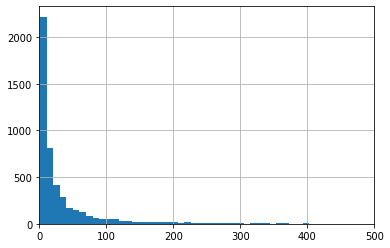

In [30]:
df_brand_rr.loc[df_brand_rr['lifetime_cured_orders']<500, 'lifetime_cured_orders'].hist(bins=50)
plt.xlim(0, 500);

## Want to plot how return rate evolves as more orders come in

X-axis is brand_order rank in brand's history

Y-axis is difference to final return rate OR difference to next return rate


In [31]:
df_brand_rr.head()

,brand_id,return_rate_order_1,return_rate_order_2,return_rate_order_3,return_rate_order_4,return_rate_order_5,return_rate_order_6,return_rate_order_7,return_rate_order_8,return_rate_order_9,...,smoothed1000_return_rate_order_41,smoothed1000_return_rate_order_42,smoothed1000_return_rate_order_43,smoothed1000_return_rate_order_44,smoothed1000_return_rate_order_45,smoothed1000_return_rate_order_46,smoothed1000_return_rate_order_47,smoothed1000_return_rate_order_48,smoothed1000_return_rate_order_49,lifetime_cured_orders
0,539,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099361,0.099266,0.099171,0.099076,0.098981,0.098887,0.098792,0.098698,0.098604,11
1,1581,0.0,0.0,0.000000,0.000000,0.224175,0.160071,0.144509,0.131988,0.160103,...,0.102336,0.104389,0.104310,0.104210,0.104227,0.104244,0.104261,0.104277,0.104294,44
2,3077,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.102412,0.102389,0.102365,0.102341,0.102317,0.102293,0.102270,0.102246,0.102222,19
3,3510,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.099518,0.099419,0.099324,0.099230,0.099135,0.099044,0.098951,0.098858,0.098765,96
4,3866,0.0,0.0,0.212985,0.212985,0.212985,0.212985,0.212985,0.212985,0.212985,...,0.107750,0.107851,0.107952,0.108052,0.108153,0.108253,0.108353,0.108453,0.108553,3


In [32]:
df_brand_rr.shape

(4849, 590)

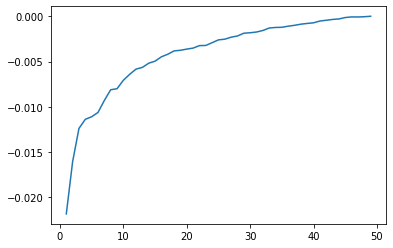

In [33]:
rr_differences = [
    (df_brand_rr['return_rate_order_49'] - df_brand_rr['return_rate_order_'+str(x)]).mean() 
    for x in range(1, 50)
]

plt.plot(range(1, 50), rr_differences)
         

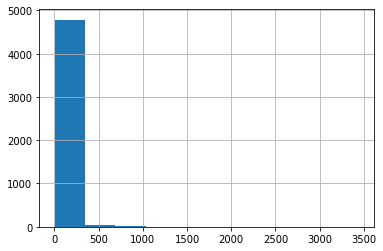

In [34]:
(df_brand_rr['lifetime_cured_orders'].fillna(0).astype(int)).hist()

In [35]:
df_brand_rr['lifetime_cured_orders'].value_counts().head()

1    458
2    340
4    247
3    244
5    230
Name: lifetime_cured_orders, dtype: int64

In [36]:
df_brand_rr['lifetime_cured_orders'].fillna(0, inplace=True)

In [38]:
df_brand_rr['last_return_rate'] = df_brand_rr.apply(
    lambda x: x['return_rate_order_' 
                + str(
                    min(x['lifetime_cured_orders'], 49)
                )
               ] 
    , axis=1
)

## For brands that eventually get at least min_orders cured orders, how was the initial estimate off?

In [39]:
min_orders = 15

In [40]:
# Loop over return rate order index:
rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
#         print(brands_off)
    rr_order_dict[no] = brands_off
        

### Version using retailer weight

In [50]:
for c in df_brand_rr.columns.tolist():
    if 'weighted_return_rate' in c:
        df_brand_rr[c] = df_brand_rr[c].astype(float)

In [51]:
# Loop over return rate order index:
weighted_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['weighted_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
#         print(brands_off)
    weighted_rr_order_dict[no] = brands_off
        

### Build a smoothed version:

In [52]:
df['returned_gmv_dollars'].sum() / df['total_gmv_dollars'].sum()

0.1034352910697645

In [53]:
# Loop over return rate order index:
smoothed1_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed1_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed1_rr_order_dict[no] = brands_off
        

In [54]:
# Loop over return rate order index:
smoothed2_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed2_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed2_rr_order_dict[no] = brands_off
        

In [55]:
# Loop over return rate order index:
smoothed3_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed3_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed3_rr_order_dict[no] = brands_off
        

In [56]:
# Loop over return rate order index:
smoothed4_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed4_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed4_rr_order_dict[no] = brands_off
        

In [57]:
# Loop over return rate order index:
smoothed5_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed5_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed5_rr_order_dict[no] = brands_off
        

In [58]:
# Loop over return rate order index:
smoothed6_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed6_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed6_rr_order_dict[no] = brands_off
        

In [59]:
# Loop over return rate order index:
smoothed7_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed7_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed7_rr_order_dict[no] = brands_off
        

In [60]:
# Loop over return rate order index:
smoothed10_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed10_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed10_rr_order_dict[no] = brands_off
        

In [61]:
# Loop over return rate order index:
smoothed20_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed20_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed20_rr_order_dict[no] = brands_off
        

In [62]:
# Loop over return rate order index:
smoothed1000_rr_order_dict = {}
thresholds = [0.005*x for x in range(0, 200)]
for no in range(1,50):
    
    # Loop over difference thresholds
    brands_off = []
    for t in thresholds:
        brands_off.append(df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= min_orders) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['smoothed1000_return_rate_order_'+str(no)]) <= t),
                        'brand_id'].nunique() \
                          / df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= min_orders, 'brand_id'].nunique()
                         )
    smoothed1000_rr_order_dict[no] = brands_off
        

In [63]:
df_brand_rr.loc[(df_brand_rr['lifetime_cured_orders'] >= 15) &
                                          (abs(df_brand_rr['last_return_rate'] 
                                              - df_brand_rr['return_rate_order_'+str(no)]) <= 10000),
                        'brand_id'].nunique()

2229

In [64]:
df_brand_rr.loc[df_brand_rr['lifetime_cured_orders'] >= 15, 'brand_id'].nunique()

2229

In [65]:
len(rr_order_dict[4])

200

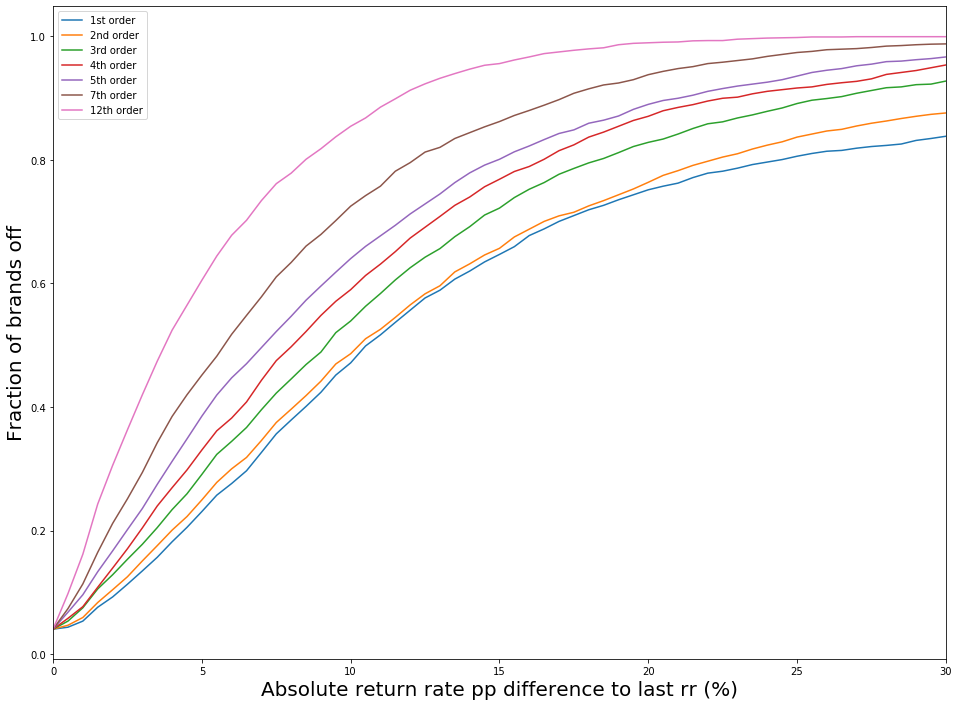

In [66]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], rr_order_dict[1], label='1st order')
plt.plot([100*x for x in thresholds], rr_order_dict[2], label='2nd order')
plt.plot([100*x for x in thresholds], rr_order_dict[3], label='3rd order')
plt.plot([100*x for x in thresholds], rr_order_dict[4], label='4th order')
plt.plot([100*x for x in thresholds], rr_order_dict[5], label='5th order')
# plt.plot([100*x for x in thresholds], rr_order_dict[6], label='6th order')
plt.plot([100*x for x in thresholds], rr_order_dict[7], label='7th order')
plt.plot([100*x for x in thresholds], rr_order_dict[12], label='12th order')
# plt.plot([100*x for x in thresholds], rr_order_dict[20], label='20th order')
# plt.plot([100*x for x in thresholds], rr_order_dict[30], label='30th order')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

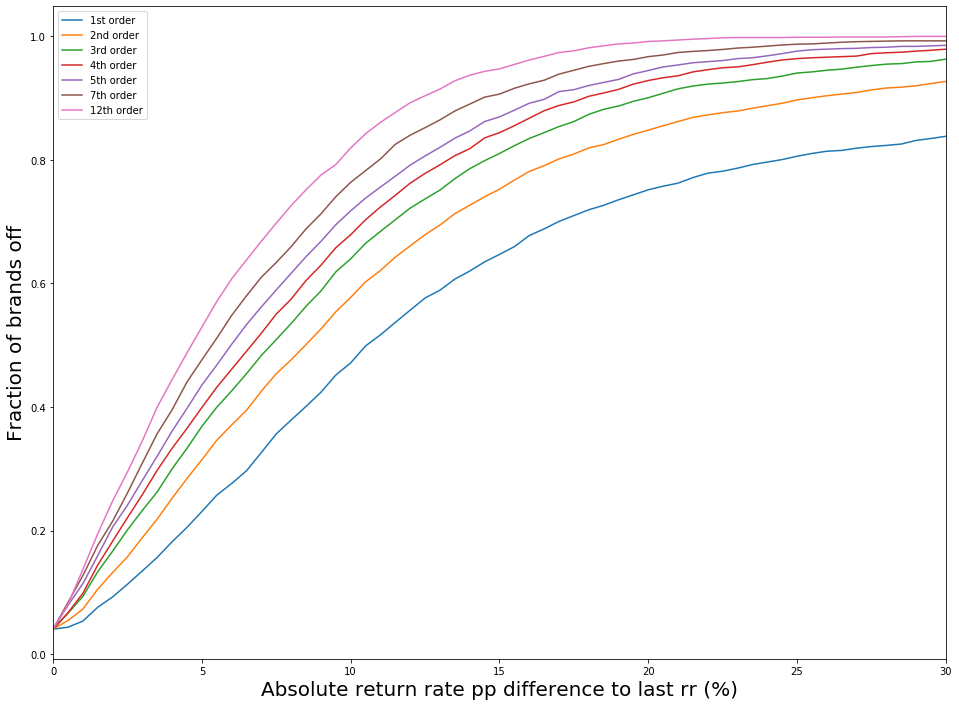

In [67]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], weighted_rr_order_dict[1], label='1st order')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[2], label='2nd order')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[3], label='3rd order')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[4], label='4th order')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[5], label='5th order')
# plt.plot([100*x for x in thresholds], weighted_rr_order_dict[6], label='6th order')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[7], label='7th order')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[12], label='12th order')
# plt.plot([100*x for x in thresholds], weighted_rr_order_dict[20], label='20th order')
# plt.plot([100*x for x in thresholds], weighted_rr_order_dict[30], label='30th order')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

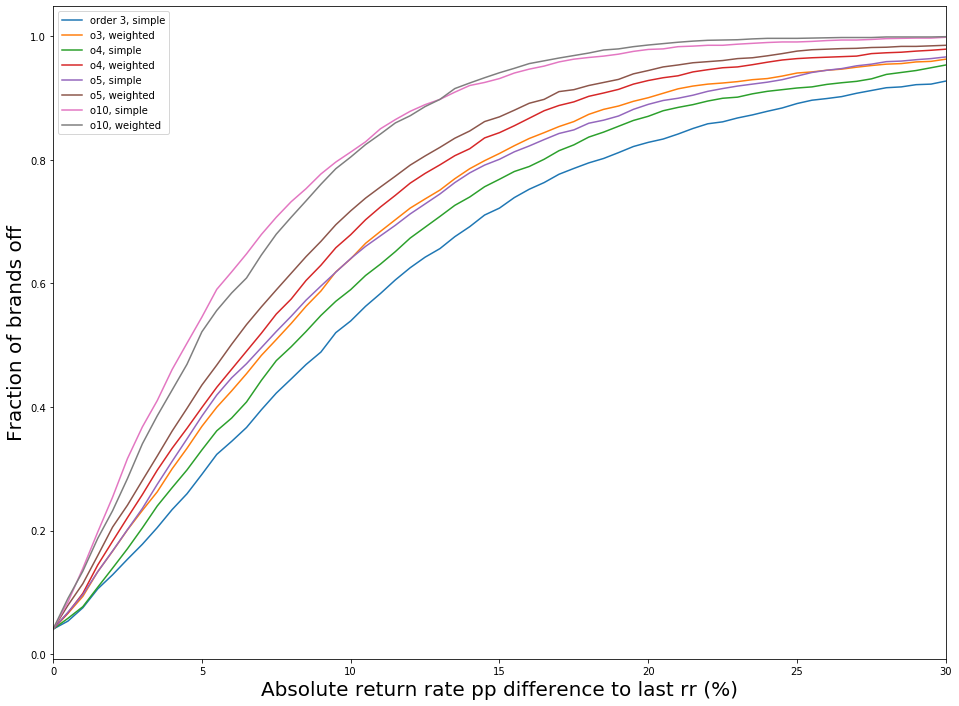

In [68]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], rr_order_dict[3], label='order 3, simple')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[3], label='o3, weighted')
plt.plot([100*x for x in thresholds], rr_order_dict[4], label='o4, simple')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[4], label='o4, weighted')
plt.plot([100*x for x in thresholds], rr_order_dict[5], label='o5, simple')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[5], label='o5, weighted')
plt.plot([100*x for x in thresholds], rr_order_dict[10], label='o10, simple')
plt.plot([100*x for x in thresholds], weighted_rr_order_dict[10], label='o10, weighted')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[1], label='1st order')
plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[2], label='2nd order')
plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[3], label='3rd order')
plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[4], label='4th order')
plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[5], label='5th order')
# plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[6], label='6th order')
plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[7], label='7th order')
plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[12], label='12th order')
# plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[20], label='20th order')
# plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[30], label='30th order')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[1], label='1st order')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[2], label='2nd order')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[3], label='3rd order')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[4], label='4th order')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[5], label='5th order')
# plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[6], label='6th order')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[7], label='7th order')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[12], label='12th order')
# plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[20], label='20th order')
# plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[30], label='30th order')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[1], label='1st order')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[2], label='2nd order')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[3], label='3rd order')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[4], label='4th order')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[5], label='5th order')
# plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[6], label='6th order')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[7], label='7th order')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[12], label='12th order')
# plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[20], label='20th order')
# plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[30], label='30th order')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[1], label='1st order')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[2], label='2nd order')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[3], label='3rd order')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[4], label='4th order')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[5], label='5th order')
# plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[6], label='6th order')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[7], label='7th order')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[12], label='12th order')
# plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[20], label='20th order')
# plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[30], label='30th order')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[1], label='1st order')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[2], label='2nd order')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[3], label='3rd order')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[4], label='4th order')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[5], label='5th order')
# plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[6], label='6th order')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[7], label='7th order')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[12], label='12th order')
# plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[20], label='20th order')
# plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[30], label='30th order')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[4], label='4th order, ss=1')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[4], label='4th order, ss=2')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[4], label='4th order, ss=3')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[4], label='4th order, ss=4')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[4], label='4th order, ss=5')
plt.plot([100*x for x in thresholds], smoothed6_rr_order_dict[4], label='4th order, ss=6')
plt.plot([100*x for x in thresholds], smoothed7_rr_order_dict[4], label='4th order, ss=7')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[5], label='5th order, ss=1')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[5], label='5th order, ss=2')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[5], label='5th order, ss=3')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[5], label='5th order, ss=4')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[5], label='5th order, ss=5')
plt.plot([100*x for x in thresholds], smoothed6_rr_order_dict[5], label='5th order, ss=6')
plt.plot([100*x for x in thresholds], smoothed7_rr_order_dict[5], label='5th order, ss=7')
plt.plot([100*x for x in thresholds], smoothed10_rr_order_dict[5], label='5th order, ss=10')
plt.plot([100*x for x in thresholds], smoothed20_rr_order_dict[5], label='5th order, ss=20')
plt.plot([100*x for x in thresholds], smoothed1000_rr_order_dict[5], label='5th order, ss=1000')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,30)

plt.legend(loc='best');

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], smoothed1_rr_order_dict[5], label='5th order, ss=1')
plt.plot([100*x for x in thresholds], smoothed2_rr_order_dict[5], label='5th order, ss=2')
plt.plot([100*x for x in thresholds], smoothed3_rr_order_dict[5], label='5th order, ss=3')
plt.plot([100*x for x in thresholds], smoothed4_rr_order_dict[5], label='5th order, ss=4')
plt.plot([100*x for x in thresholds], smoothed5_rr_order_dict[5], label='5th order, ss=5')
plt.plot([100*x for x in thresholds], smoothed6_rr_order_dict[5], label='5th order, ss=6')
plt.plot([100*x for x in thresholds], smoothed7_rr_order_dict[5], label='5th order, ss=7')
plt.plot([100*x for x in thresholds], smoothed10_rr_order_dict[5], label='5th order, ss=10')
plt.plot([100*x for x in thresholds], smoothed20_rr_order_dict[5], label='5th order, ss=20')
plt.plot([100*x for x in thresholds], smoothed1000_rr_order_dict[5], label='5th order, ss=1000')

plt.ylabel('Fraction of brands off', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
plt.xlim(0,5)

plt.legend(loc='best');

In [ ]:
asdasdsd

In [ ]:
cum_rr_dict = {}
for k,l  in rr_order_dict.items():
    cum_l = []
    for i, e in enumerate(l):
        cum_l.append(np.sum(l[:i]))
    
    cum_rr_dict[k] = cum_l

In [ ]:
plt.figure(figsize=(16, 12));

plt.plot([100*x for x in thresholds], cum_rr_dict[1], label='1st order')
plt.plot([100*x for x in thresholds], cum_rr_dict[2], label='2nd order')
plt.plot([100*x for x in thresholds], cum_rr_dict[3], label='3rd order')
plt.plot([100*x for x in thresholds], cum_rr_dict[4], label='4th order')
plt.plot([100*x for x in thresholds], cum_rr_dict[5], label='5th order')
# plt.plot([100*x for x in thresholds], cum_rr_dict[6], label='6th order')
plt.plot([100*x for x in thresholds], cum_rr_dict[7], label='7th order')
plt.plot([100*x for x in thresholds], cum_rr_dict[12], label='12th order')
# plt.plot([100*x for x in thresholds], cum_rr_dict[20], label='20th order')
# plt.plot([100*x for x in thresholds], cum_rr_dict[30], label='30th order')

plt.ylabel('Cumulative fraction of brands off by leq x-axis value', fontsize=20);
plt.xlabel('Absolute return rate pp difference to last rr (%)', fontsize=20);
# plt.xlim(0,20)

plt.legend(loc='best');